# Import

In [50]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
import numpy as np
import torch
from torch import nn, optim
from torch import autograd
import torch.nn.functional as F
from torch.nn import Parameter
from torchvision import datasets, transforms
from torchvision.utils import save_image
from torch.utils.data import Dataset,DataLoader,Subset
from PIL import Image,ImageOps,ImageEnhance

import cv2
import albumentations as A
from albumentations.pytorch import ToTensor

import glob
import xml.etree.ElementTree as ET #for parsing XML
import shutil
from tqdm import tqdm
import time
import random
import os
from tqdm import tqdm_notebook

In [73]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [51]:
def show_images(images, cols = 1, titles = None):
    """Display a list of images in a single figure with matplotlib.
    
    Parameters
    ---------
    images: List of np.arrays compatible with plt.imshow.
    
    cols (Default = 1): Number of columns in figure (number of rows is 
                        set to np.ceil(n_images/float(cols))).
    
    titles: List of titles corresponding to each image. Must have
            the same length as titles.
    """
    assert((titles is None)or (len(images) == len(titles)))
    n_images = len(images)
    if titles is None: titles = ['Image (%d)' % i for i in range(1,n_images + 1)]
    fig = plt.figure()
    for n, (image, title) in enumerate(zip(images, titles)):
        a = fig.add_subplot(cols, np.ceil(n_images/float(cols)), n + 1)
        if image.ndim == 2:
            plt.gray()
        plt.imshow(image)
        a.set_title(title)
    fig.set_size_inches(np.array(fig.get_size_inches()) * n_images)
    plt.show()

# Data loader

In [52]:
# generate 64x64 images!
#resize_size = 84
img_size    = 128

mean = 0.5, 0.5, 0.5
std = 0.5, 0.5, 0.5

transform1 = transforms.Compose([transforms.Resize(img_size)])
#transform1 = transforms.Compose([transforms.Resize((resize_size,resize_size))])

transform2 = transforms.Compose([transforms.RandomCrop(img_size),
                                 transforms.RandomHorizontalFlip(p=0.5),
                                 transforms.ToTensor(),
                                 transforms.Normalize(mean=mean, std=std),
                                ])


In [53]:
class MotorbikeDataset(Dataset):
    def __init__(self, path, img_list, transform1=None, transform2=None):
        self.path      = path
        self.img_list  = img_list
        self.transform1 = transform1
        self.transform2 = transform2
        self.load_data(img_list)

    def __len__(self):
        return len(self.img_list)
    
    def __getitem__(self,idx):
        img = self.images[idx]
        
        if self.transform2 is not None:
            img = self.transform2(img)
        return img
    
    def load_data(self, img_list):
        self.images = []
        
        for idx, path in enumerate(img_list):
            origin_img = Image.open(os.path.join(self.path, self.img_list[idx]))
            img = origin_img.copy()
            origin_img.close()
            img = self.transform1(img)
            self.images.append(img)
        return self.images

# Model

In [54]:
def conv3x3(in_channel, out_channel): #not change resolusion
    return nn.Conv2d(in_channel,out_channel,
                      kernel_size=3,stride=1,padding=1,dilation=1,bias=False)

def conv1x1(in_channel, out_channel): #not change resolution
    return nn.Conv2d(in_channel,out_channel,
                      kernel_size=1,stride=1,padding=0,dilation=1,bias=False)

def init_weight(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.orthogonal_(m.weight, gain=1)
        if m.bias is not None:
            m.bias.data.zero_()
            
    elif classname.find('Batch') != -1:
        m.weight.data.normal_(1,0.02)
        m.bias.data.zero_()
    
    elif classname.find('Linear') != -1:
        nn.init.orthogonal_(m.weight, gain=1)
        if m.bias is not None:
            m.bias.data.zero_()
    
    elif classname.find('Embedding') != -1:
        nn.init.orthogonal_(m.weight, gain=1)
        

class cSEBlock(nn.Module):
    def __init__(self, c, feat):
        super().__init__()
        self.attention_fc = nn.Linear(feat,1, bias=False)
        self.bias         = nn.Parameter(torch.zeros((1,c,1), requires_grad=True))
        self.sigmoid      = nn.Sigmoid()
        self.dropout      = nn.Dropout2d(0.1)
        
    def forward(self,inputs):
        batch,c,h,w = inputs.size()
        x = inputs.view(batch,c,-1)
        x = self.attention_fc(x) + self.bias
        x = x.view(batch,c,1,1)
        x = self.sigmoid(x)
        x = self.dropout(x)
        return inputs * x

class sSEBlock(nn.Module):
    def __init__(self, c, h, w):
        super().__init__()
        self.attention_fc = nn.Linear(c,1, bias=False).apply(init_weight)
        self.bias         = nn.Parameter(torch.zeros((1,h,w,1), requires_grad=True))
        self.sigmoid      = nn.Sigmoid()
        
    def forward(self,inputs):
        batch,c,h,w = inputs.size()
        x = torch.transpose(inputs, 1,2) #(*,c,h,w)->(*,h,c,w)
        x = torch.transpose(x, 2,3) #(*,h,c,w)->(*,h,w,c)
        x = self.attention_fc(x) + self.bias
        x = torch.transpose(x, 2,3) #(*,h,w,1)->(*,h,1,w)
        x = torch.transpose(x, 1,2) #(*,h,1,w)->(*,1,h,w)
        x = self.sigmoid(x)
        return inputs * x
    

class scSEBlock(nn.Module):
    def __init__(self, c, h, w):
        super().__init__()
        self.cSE = cSEBlock(c,h*w)
        self.sSE = sSEBlock(c,h,w)
    
    def forward(self, inputs):
        x1 = self.cSE(inputs)
        x2 = self.sSE(inputs)
        return x1+x2
    

class Attention(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.channels = channels
        self.theta    = nn.utils.spectral_norm(conv1x1(channels, channels//8)).apply(init_weight)
        self.phi      = nn.utils.spectral_norm(conv1x1(channels, channels//8)).apply(init_weight)
        self.g        = nn.utils.spectral_norm(conv1x1(channels, channels//2)).apply(init_weight)
        self.o        = nn.utils.spectral_norm(conv1x1(channels//2, channels)).apply(init_weight)
        self.gamma    = nn.Parameter(torch.tensor(0.), requires_grad=True)
        
    def forward(self, inputs):
        batch,c,h,w = inputs.size()
        theta = self.theta(inputs) #->(*,c/8,h,w)
        phi   = F.max_pool2d(self.phi(inputs), [2,2]) #->(*,c/8,h/2,w/2)
        g     = F.max_pool2d(self.g(inputs), [2,2]) #->(*,c/2,h/2,w/2)
        
        theta = theta.view(batch, self.channels//8, -1) #->(*,c/8,h*w)
        phi   = phi.view(batch, self.channels//8, -1) #->(*,c/8,h*w/4)
        g     = g.view(batch, self.channels//2, -1) #->(*,c/2,h*w/4)
        
        beta = F.softmax(torch.bmm(theta.transpose(1,2), phi), -1) #->(*,h*w,h*w/4)
        o    = self.o(torch.bmm(g, beta.transpose(1,2)).view(batch,self.channels//2,h,w)) #->(*,c,h,w)
        return self.gamma*o + inputs
        
    
class ConditionalNorm(nn.Module):
    def __init__(self, in_channel, n_condition):
        super().__init__()
        self.bn = nn.BatchNorm2d(in_channel, affine=False) #no learning parameters
        self.embed = nn.Linear(n_condition, in_channel* 2)
        
        nn.init.orthogonal_(self.embed.weight.data[:, :in_channel], gain=1)
        self.embed.weight.data[:, in_channel:].zero_()

    def forward(self, inputs, label):
        out = self.bn(inputs)
        embed = self.embed(label.float())
        gamma, beta = embed.chunk(2, dim=1)
        gamma = gamma.unsqueeze(2).unsqueeze(3)
        beta = beta.unsqueeze(2).unsqueeze(3)
        out = gamma * out + beta
        return out

In [55]:
#BigGAN + leaky_relu           
class ResBlock_G(nn.Module):
    def __init__(self, in_channel, out_channel, condition_dim, upsample=True):
        super().__init__()
        self.cbn1 = ConditionalNorm(in_channel, condition_dim)
        self.upsample = nn.Sequential()
        if upsample:
            self.upsample.add_module('upsample',nn.Upsample(scale_factor=2, mode='nearest'))
        self.conv3x3_1 = nn.utils.spectral_norm(conv3x3(in_channel, out_channel)).apply(init_weight)
        self.cbn2 = ConditionalNorm(out_channel, condition_dim)
        self.conv3x3_2 = nn.utils.spectral_norm(conv3x3(out_channel, out_channel)).apply(init_weight) 
        self.conv1x1   = nn.utils.spectral_norm(conv1x1(in_channel, out_channel)).apply(init_weight)
        
    def forward(self, inputs, condition):
        x  = F.leaky_relu(self.cbn1(inputs, condition))
        x  = self.upsample(x)
        x  = self.conv3x3_1(x)
        x  = self.conv3x3_2(F.leaky_relu(self.cbn2(x, condition)))
        x += self.conv1x1(self.upsample(inputs)) #shortcut
        return x

class Generator(nn.Module):
    def __init__(self, n_feat, codes_dim, n_classes=0):
        super().__init__()
        self.codes_dim = codes_dim
        self.fc   = nn.Sequential(
            nn.utils.spectral_norm(nn.Linear(codes_dim, 16*n_feat*4*4)).apply(init_weight)
        )
        self.res1 = ResBlock_G(16*n_feat, 16*n_feat, codes_dim+n_classes, upsample=True)
        self.res2 = ResBlock_G(16*n_feat,  8*n_feat, codes_dim+n_classes, upsample=True)
        self.res3 = ResBlock_G( 8*n_feat,  4*n_feat, codes_dim+n_classes, upsample=True)
        self.attn = Attention(  2*n_feat)
        self.res4 = ResBlock_G( 4*n_feat,  2*n_feat, codes_dim+n_classes, upsample=True)
        self.res5 = ResBlock_G( 2*n_feat,  n_feat, codes_dim+n_classes, upsample=True)
        self.conv = nn.Sequential(
            #nn.BatchNorm2d(2*n_feat).apply(init_weight),
            nn.LeakyReLU(),
            nn.utils.spectral_norm(conv3x3(n_feat, 3)).apply(init_weight),
        )
        
    def forward(self, z):
        '''
        z.shape = (*,Z_DIM)
        cd.shape = (*,n_classes)
        '''
        batch = z.size(0)
        z = z.squeeze()
#         label_ohe = label_ohe.squeeze()
        codes = torch.split(z, self.codes_dim, dim=1)
        
        x = self.fc(codes[0]) #->(*,16ch*4*4)
        x = x.view(batch,-1,4,4) #->(*,16ch,4,4)
        
        condition = torch.cat([codes[1]], dim=1) #(*,codes_dim+n_classes)
        x = self.res1(x, condition)#->(*,16ch,8,8)
        
        condition = torch.cat([codes[2]], dim=1)
        x = self.res2(x, condition) #->(*,8ch,16,16)
        
        condition = torch.cat([codes[3]], dim=1)
        x = self.res3(x, condition) #->(*,4ch,32,32)
        
        condition = torch.cat([codes[4]], dim=1)
        x = self.res4(x, condition) #->(*,2ch,64,64)
        x = self.attn(x) #not change shape
        
        condition = torch.cat([codes[5]], dim=1)
        x = self.res5(x, condition) #->(*,2ch,128,128)
        
        x = self.conv(x) #->(*,3,128,128)
        x = torch.tanh(x)
        return x
    

class ResBlock_D(nn.Module):
    def __init__(self, in_channel, out_channel, downsample=True):
        super().__init__()
        self.layer = nn.Sequential(
            nn.LeakyReLU(0.2),
            nn.utils.spectral_norm(conv3x3(in_channel, out_channel)).apply(init_weight),
            nn.LeakyReLU(0.2),
            nn.utils.spectral_norm(conv3x3(out_channel, out_channel)).apply(init_weight),
        )
        self.shortcut = nn.Sequential(
            nn.utils.spectral_norm(conv1x1(in_channel,out_channel)).apply(init_weight),
        )
        if downsample:
            self.layer.add_module('avgpool',nn.AvgPool2d(kernel_size=2,stride=2))
            self.shortcut.add_module('avgpool',nn.AvgPool2d(kernel_size=2,stride=2))
        
    def forward(self, inputs):
        x  = self.layer(inputs)
        x += self.shortcut(inputs)
        return x
    

class Discriminator(nn.Module):
    def __init__(self, n_feat):
        super().__init__()
        self.res1 = ResBlock_D(3, n_feat, downsample=True)
        self.attn = Attention(n_feat)
        self.res2 = ResBlock_D(  n_feat, 2*n_feat, downsample=True)
        self.res3 = ResBlock_D(2*n_feat, 4*n_feat, downsample=True)
        self.res4 = ResBlock_D(4*n_feat, 8*n_feat, downsample=True)
        self.res5 = ResBlock_D(8*n_feat,16*n_feat, downsample=True)
        self.res6 = ResBlock_D(16*n_feat,32*n_feat, downsample=False)
        
        self.fc   = nn.utils.spectral_norm(nn.Linear(32*n_feat,1)).apply(init_weight)
        
    def forward(self, inputs):
        batch = inputs.size(0) #(*,3,128,128)
        h = self.res1(inputs) #->(*,ch,64,64)
        h = self.attn(h) #not change shape
        h = self.res2(h) #->(*,2ch,32,32)
        h = self.res3(h) #->(*,4ch,16,16)
        h = self.res4(h) #->(*,8ch,8,8)
        h = self.res5(h) #->(*,16ch,4,4)
        h = self.res6(h) #->(*,32ch,4,4)
        
        h = torch.sum((F.leaky_relu(h,0.2)).view(batch,-1,4*4), dim=2) #GlobalSumPool ->(*,16ch)
        outputs = self.fc(h) #->(*,1)

        if not HINGE_LOSS:
            outputs = torch.sigmoid(outputs)
            
        return outputs

In [56]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [57]:
def generate_img(netG,fixed_noise,fixed_aux_labels=None):
    if fixed_aux_labels is not None:
        gen_image = netG(fixed_noise,fixed_aux_labels).to('cpu').clone().detach().squeeze(0)
    else:
        gen_image = netG(fixed_noise).to('cpu').clone().detach().squeeze(0)
    #denormalize
    gen_image = gen_image*0.5 + 0.5
    gen_image_numpy = gen_image.numpy().transpose(0,2,3,1)
    return gen_image_numpy

def show_generate_imgs(netG, fixed_noise, max_image=4, fixed_aux_labels=None):
    gen_images_numpy = generate_img(netG,fixed_noise,fixed_aux_labels)

    fig = plt.figure(figsize=(25, 16))
    # display 10 images from each class
    for i, img in enumerate(gen_images_numpy[:max_image]):
        ax = fig.add_subplot(4, 8, i + 1, xticks=[], yticks=[])
        plt.imshow(img)

# Vairables

In [58]:
#random seeds
seed = 2019
random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)

HINGE_LOSS  = True
BATCH_SIZE  = 4
NUM_WORKERS = 4
EMA = False
LABEL_NOISE = False #True
LABEL_NOISE_PROB = 0.01

Z_DIM     = 60 #120
CODES_DIM = 10 #20

LR_G = 4*3e-4
LR_D = 4*3e-4
MILESTONES = [30,60] #None
SCHEDULER_GAMMA = 0.5

DUPLICATES = False #True

SHARPEN = False
SHARPEN_MAGNITUDE = 1

In [59]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

# Traning loop

In [60]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [61]:
class EMA():
    def __init__(self, mu):
        self.mu = mu
        self.shadow = {}

    def register(self, name, val):
        self.shadow[name] = val.clone()

    def __call__(self, name, x):
        assert name in self.shadow
        new_average = (1.0 - self.mu) * x + self.mu * self.shadow[name]
        self.shadow[name] = new_average.clone()
        return new_average

In [62]:
def get_models():
    netG = Generator(n_feat=16, codes_dim=CODES_DIM).to(device) #z.shape=(*,120)
    netD = Discriminator(n_feat=19).to(device)
    return netD, netG

In [63]:
def run(lr_G=3e-4,lr_D=3e-4, beta1=0.0, beta2=0.999, nz=120, epochs=2, 
        n_ite_D=1, ema_decay_rate=0.999, show_epoch_list=None, output_freq=10):
    n_classes = 0
    
    netD, netG = get_models()
    if EMA == True:
        print("Setup EMA")
        ema = EMA(ema_decay_rate)
        for name, param in netG.named_parameters():
            if param.requires_grad:
                ema.register(name, param.data) 
                
    print(count_parameters(netG))
    print(count_parameters(netD))
    
    real_label = 0.9
    fake_label = 0
    
    D_loss_list = []
    G_loss_list = []
    
    dis_criterion = nn.BCELoss().to(device)

    optimizerD = optim.Adam(netD.parameters(), lr=lr_D, betas=(beta1, beta2))
    optimizerG = optim.Adam(netG.parameters(), lr=lr_G, betas=(beta1, beta2))
    
    if MILESTONES is not None:
        schedulerD = optim.lr_scheduler.MultiStepLR(optimizerD, milestones=MILESTONES, 
                                                    gamma=SCHEDULER_GAMMA, last_epoch=-1)
        schedulerG = optim.lr_scheduler.MultiStepLR(optimizerG, milestones=MILESTONES, 
                                                    gamma=SCHEDULER_GAMMA, last_epoch=-1)
    
    fixed_noise = torch.randn(32, nz, 1, 1, device=device)
    netG.train()
    netD.train()

    ### training here
    for epoch in range(1,epochs+1):
#         if elapsed_time(start_time) > TIME_LIMIT:
#             print(f'elapsed_time go beyond {TIME_LIMIT} sec')
#             break
        
        if MILESTONES is not None:
            print('lrG = ', schedulerG.get_lr()[0])
            print('lrD = ', schedulerD.get_lr()[0])
        
        D_running_loss = 0
        G_running_loss = 0
        for ii, data in tqdm_notebook(enumerate(train_loader), total=len(train_loader)):
            ############################
            # (1) Update D network
            ###########################
            for _ in range(n_ite_D):
                
                if LABEL_NOISE:
                    real_label = 0.9
                    fake_label = 0
                    if np.random.random() < LABEL_NOISE_PROB:
                        real_label = 0
                        fake_label = 0.9
                    
                # train with real
                netD.zero_grad()
                real_images = data.to(device, non_blocking=True) 
                batch_size  = real_images.size(0)
                dis_labels  = torch.full((batch_size, 1), real_label, device=device) #shape=(*,)
#                 aux_labels  = data['label'].long().to(device, non_blocking=True) #shape=(*,)
                dis_output  = netD(real_images) #dis shape=(*,1)
                
                if HINGE_LOSS:
                    errD_real = torch.mean(F.relu(1-dis_output))
                else:
                    errD_real  = dis_criterion(dis_output, dis_labels)
                errD_real.backward(retain_graph=True)

#                 # train with fake
                noise  = torch.randn(batch_size, nz, 1, 1, device=device)
#                 #noise = noise / noise.norm(dim=1, keepdim=True)
#                 aux_labels     = np.random.randint(0,n_classes, batch_size)
#                 aux_labels_ohe = np.eye(n_classes)[aux_labels]
#                 aux_labels_ohe = torch.from_numpy(aux_labels_ohe[:,:,np.newaxis,np.newaxis])
#                 aux_labels_ohe = aux_labels_ohe.float().to(device, non_blocking=True)
#                 aux_labels = torch.from_numpy(aux_labels).long().to(device, non_blocking=True)
                
                fake = netG(noise) #output shape=(*,3,64,64)
                dis_labels.fill_(fake_label)
                dis_output = netD(fake.detach())
                if HINGE_LOSS:
                    errD_fake = torch.mean(F.relu(1+dis_output))
                else:
                    errD_fake  = dis_criterion(dis_output, dis_labels)
                errD_fake.backward(retain_graph=True)
                D_running_loss += (errD_real.item() + errD_fake.item())/len(train_loader)
                optimizerD.step()

            ############################
            # (2) Update G network
            ###########################
            netG.zero_grad()
            dis_labels.fill_(real_label)  # fake labels are real for generator cost
            noise = torch.randn(batch_size, nz, 1, 1, device=device)
#             aux_labels     = np.random.randint(0,n_classes, batch_size)
#             aux_labels_ohe = np.eye(n_classes)[aux_labels]
#             aux_labels_ohe = torch.from_numpy(aux_labels_ohe[:,:,np.newaxis,np.newaxis])
#             aux_labels_ohe = aux_labels_ohe.float().to(device, non_blocking=True)
#             aux_labels = torch.from_numpy(aux_labels).long().to(device, non_blocking=True)
            fake  = netG(noise)
            
            dis_output = netD(fake)
            if HINGE_LOSS:
                errG = - torch.mean(dis_output)
            else:
                errG   = dis_criterion(dis_output, dis_labels)
            errG.backward(retain_graph=True)
            G_running_loss += errG.item()/len(train_loader)
            optimizerG.step()
        
        if MILESTONES is not None:
            schedulerD.step()
            schedulerG.step()
        
        if EMA == True:
            print("Setup EMA")
            for name, param in netG.named_parameters():
                if param.requires_grad:
                    param.data = ema(name, param.data)
        
        #log
        D_loss_list.append(D_running_loss)
        G_loss_list.append(G_running_loss)
        
        #output
        if epoch % output_freq == 0:
            print('[{:d}/{:d}] D_loss = {:.3f}, G_loss = {:.3f}, elapsed_time = ? min'.format(epoch,epochs,D_running_loss,G_running_loss))
        
            show_generate_imgs(netG,fixed_noise)
            plt.show()
            
        if epoch % 20 == 0:
#             if not EMA:
            torch.save(netG.state_dict(), f'generator_epoch{epoch}.pth')
#             elif EMA:
#                 torch.save(netG_EMA.state_dict(), f'generator_epoch{epoch}.pth')
    
#     if not EMA:
#         torch.save(netG.state_dict(), 'generator.pth')
#     elif EMA:
#         torch.save(netG_EMA.state_dict(), 'generator.pth')
#     torch.save(netD.state_dict(), 'discriminator.pth')
    
    res = {'netG':netG,
           'netD':netD,
           'nz':nz,
           'D_loss_list':D_loss_list,
           'G_loss_list':G_loss_list,
          }
#     if EMA:
#         res['netG_EMA'] = netG_EMA
    return res

In [65]:
# img_list = os.listdir('resized128_image')

# dataset = MotorbikeDataset('resized128_image', img_list, transform1, transform2)
# train_loader = DataLoader(dataset,
#                           shuffle=True, 
#                           batch_size=BATCH_SIZE,
#                           num_workers=NUM_WORKERS, pin_memory=True)

In [66]:
def save_model_weights(model, filename, verbose=1):
    if verbose:
        print(f'-> Saving weights to {filename}')
    torch.save(model.state_dict(), filename)
    
def load_model_weights(model, filename, verbose=1):
    if verbose:
        print(f'-> Loading weights from {filename}')
    model.load_state_dict(torch.load(filename,map_location='cpu'))
    return model

In [67]:
# res = run(lr_G=5e-4,lr_D=2e-4, epochs=200, n_ite_D=1, output_freq=5)

# Prediction and evaluation

In [68]:
netD, netG = get_models()
load_model_weights(netG, 'generator_epoch20-20191017.pth');

-> Loading weights from generator_epoch20-20191017.pth


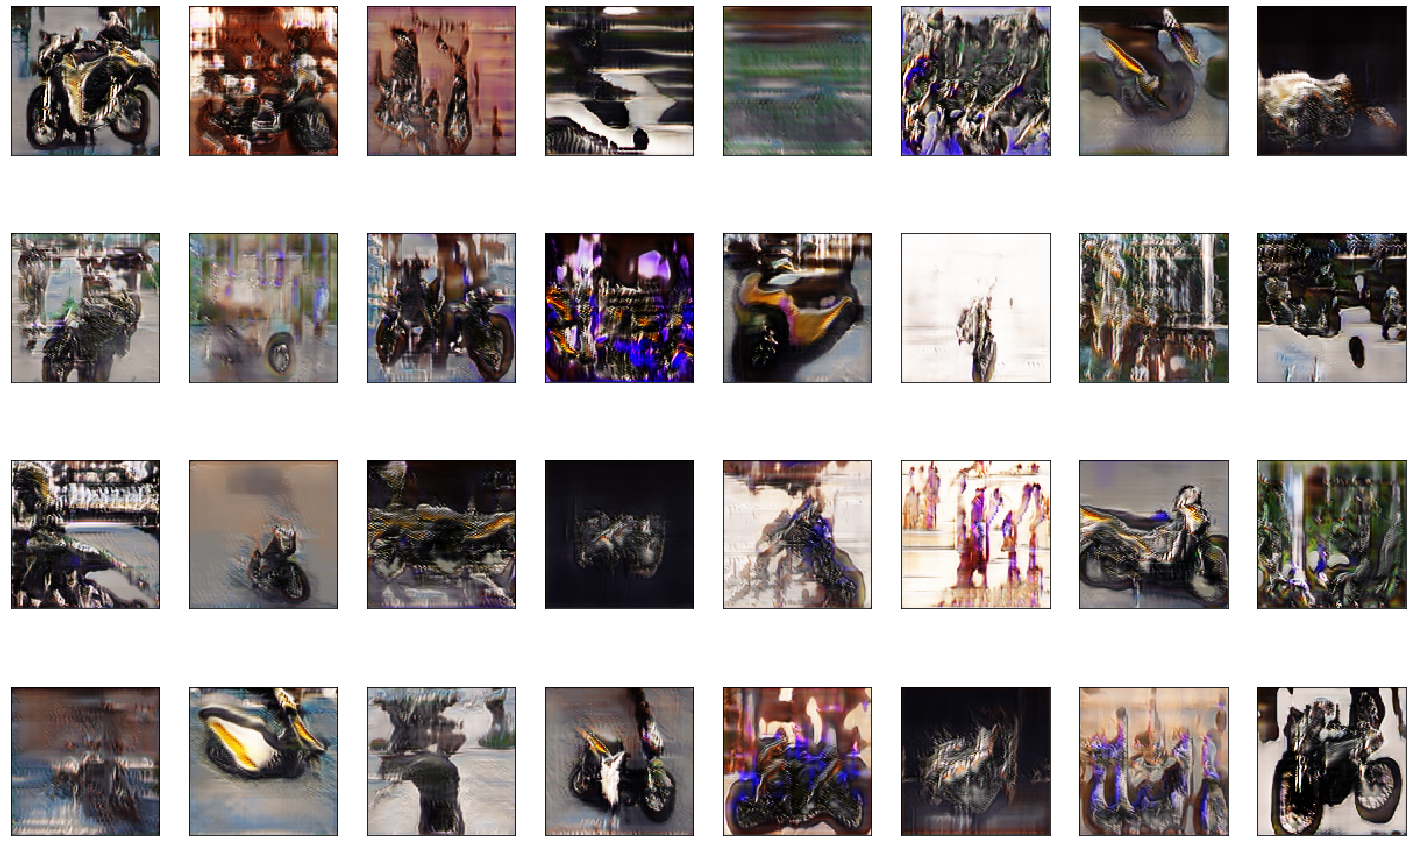

In [69]:
show_generate_imgs(netG, torch.randn(32, 120, 1, 1, device=device), max_image=32)

In [75]:
#truncation_trick
def submission_generate_images(netG, n_images=10000 , truncated=None):
    im_batch_size= 50
    nz   = 120
    
    if not os.path.exists('outputs/output_images'):
        os.mkdir('outputs/output_images')
        
    for i_batch in range(0, n_images, im_batch_size):
        if truncated is not None:
            flag = True
            while flag:
                z = np.random.randn(100*im_batch_size*nz)
                z = z[np.where(abs(z)<truncated)]
                if len(z)>=im_batch_size*nz:
                    flag=False
            gen_z = torch.from_numpy(z[:im_batch_size*nz]).view(im_batch_size,nz,1,1)
            gen_z = gen_z.float().to(device)
        else:
            gen_z = torch.randn(im_batch_size, nz, 1, 1, device=device)
#         gen_z = gen_z / gen_z.norm(dim=1, keepdim=True)
        gen_images = netG(gen_z)
        gen_images = gen_images.to("cpu").clone().detach() #shape=(*,3,h,w), torch.Tensor
        #denormalize
        gen_images = gen_images*0.5 + 0.5
        
        for i_image in range(gen_images.size(0)):
            if SHARPEN:
                img = transforms.ToPILImage()(gen_images[i_image])
                img = sharpen(img, magnitude=SHARPEN_MAGNITUDE)
                img = transforms.ToTensor()(img)
                save_image(img,
                           os.path.join(f'outputs/output_images', f'image_{i_batch+i_image:05d}.png'))
            else:
                save_image(gen_images[i_image, :, :, :],
                           os.path.join(f'outputs/output_images', f'image_{i_batch+i_image:05d}.png'))
    shutil.make_archive(f'outputs/images', 'zip', f'outputs/output_images')

In [76]:
submission_generate_images(netG, n_images=10, truncated=0.8)

In [78]:
from evaluation import evaluation
evaluation('outputs/images.zip')

Remove temp folder
[Motorbike Classifer] Load Motorbike Classifer from ./client/motorbike_classification_inception_net_128_v4_e36.pb
Load Public Embedding Features



  0%|          | 0/2 [00:00<?, ?it/s]


Compute embedding features ...
------------------------------------------------------



100%|██████████| 2/2 [00:07<00:00,  3.94s/it]


done
------------------------------------------------------
m1, m2 shape = (2048,), (2048,)
s1, s2 shape = (2048, 2048), (2048, 2048)

Starting calculating FID
- Compute sqrtm in 8.138463020324707
covmean.shape=(2048, 2048)
- Compute trace in 0.00013899803161621094
Done with FID, starting distance calculation
rows of zeros in features1 = 0
rows of zeros in features2 = 0
d.shape= (50, 10373)
np.min(d, axis=1).shape=(50,)
distance=0.25744779335708995
Compute distance with threshold=0.05

FID: 381.9760806718467
distance: 1
Final Score: 381.9760806718429


381.9760806718429